In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import copy
from model_uncond import model, sample, get_timestep_embedding, cosine_beta_schedule, q_sample


# --- Hyperparameters ---
T = 200
BATCH_SIZE = 64
IMG_SIZE = 28
EMBED_DIM = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


# --- Noise Schedule ---
# betas = torch.linspace(1e-4, 0.02, T).to(DEVICE)
betas = cosine_beta_schedule(T).to(DEVICE)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

# --- EMA Update ---
def update_ema(ema_model, model, decay):
    with torch.no_grad():
        for ema_param, param in zip(ema_model.parameters(), model.parameters()):
            ema_param.data.mul_(decay).add_(param.data, alpha=1 - decay)
            
ema_model = copy.deepcopy(model).to(DEVICE)
for param in ema_model.parameters():
    param.requires_grad = False


# --- Dataset ---
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

### Load weights

In [2]:
model.load_state_dict(torch.load(r"diff_weights/200_cos_model_epoch_300.pt"))    
ema_model.load_state_dict(torch.load(r"diff_weights/200_cos_ema_model_epoch_300.pt"))

<All keys matched successfully>

### Training loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

train_losses = []
test_losses = []

for epoch in range(2):
    model.train()
    epoch_loss = 0
    for x0, _ in train_loader:
        x0 = x0.to(DEVICE)
        t = torch.randint(0, T, (x0.size(0),), device=DEVICE)
        noise = torch.randn_like(x0)
        x_t = q_sample(x0, t, noise)
        t_emb = get_timestep_embedding(t, EMBED_DIM)

        pred_noise = model(x_t, t_emb)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        update_ema(ema_model, model, decay=0.999)

        epoch_loss += loss.item() * x0.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f}")
    
    
    # if (epoch + 1) % 50 == 0:
    #     torch.save(model.state_dict(), f"200_cos_model_epoch_{epoch+201}.pt")
    #     torch.save(ema_model.state_dict(), f"200_cos_ema_model_epoch_{epoch+201}.pt")
    #     print(f"✅ Saved model at epoch {epoch+1}")
        

    # Evaluate on test set
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x0, _ in test_loader:
            x0 = x0.to(DEVICE)
            t = torch.randint(0, T, (x0.size(0),), device=DEVICE)
            noise = torch.randn_like(x0)
            x_t = q_sample(x0, t, noise)
            t_emb = get_timestep_embedding(t, EMBED_DIM)
            pred_noise = model(x_t, t_emb)
            loss = F.mse_loss(pred_noise, noise)
            test_loss += loss.item() * x0.size(0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1} | Test Loss: {test_loss:.4f}")

# --- Plot Loss Curves ---
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

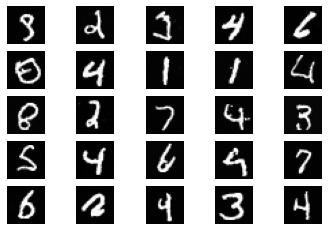

In [ ]:
num_rows = 5
num_col = 5

samples = sample(ema_model, n_samples=num_rows*num_col).cpu().detach()


for i in range(num_rows*num_col):
    plt.subplot(num_rows, num_col, i+1)
    plt.imshow(samples[i, 0], cmap='gray')
    plt.axis('off')
plt.show()